# Aggregating and weighting diverse data

In this notebook, we illustrate the aggregation of various data, and how to combine that with an adaptive scheme of computing weights.

The problem we face is that we can separate our summary statistics (=data) into subsets which are informative for different parameters, but the sizes of these subsets are not balanced. This happens frequently in practice, e.g. when one has a time series of 100 measurements, compared to a single data point. If these two statistics are informative for different parameters, then the impact of the first kind on the computed distance value can be overly high, and in addition the automatic weighting as introduced by Prangle 2017 may not reduce, or can indeed even worsen, the problem.

Thus, what we want to do is add additional "factors" by which we multiply each data point's weight. These factors take into account the number of summary statistics that are equally informative.

A toy model:

In [1]:
import pyabc
import numpy as np
import scipy as sp
import os
import tempfile
import matplotlib.pyplot as plt

N0 = 100
N1 = 1

p_true = {'p0': 5, 'p1': 10}

#def model(p):
#    ss = {}
#    for j in range(N0):
#        ss['p0_' + str(j)] = p['p0'] + sp.randn()
#    for j in range(N1):
#        ss['p1_' + str(j)] = p['p1'] + 0.1 * sp.randn()
#    return ss

def model(p):
    ss = {}
    s0 = p['p0'] + 2 * sp.randn()
    for j in range(N0):
        ss['p0_' + str(j)] = s0
    s1 = p['p1'] + 0.01 * sp.randn()
    for j in range(N1):
        ss['p1_' + str(j)] = s1
    return ss

prior = pyabc.Distribution(p0=pyabc.RV("uniform", 0, 20),
                           p1=pyabc.RV("uniform", 0, 20))

/home/yannik/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


First, we consider uniform weights of 1:

In [2]:
distance = pyabc.PNormDistance(p=1)

abc = pyabc.ABCSMC(model, prior, distance)

observation = model(p_true)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history1 = abc.run(max_nr_populations=10)

INFO:History:Start <ABCSMC(id=7, start_time=2019-09-28 17:25:48.582797, end_time=None)>
INFO:Epsilon:initial epsilon is 709.0932630733362
INFO:ABC:t:0 eps:709.0932630733362
INFO:ABC:t:1 eps:337.2075133633982
INFO:ABC:t:2 eps:166.45626832203052
INFO:ABC:t:3 eps:91.76940570659092
INFO:ABC:t:4 eps:51.77513844709196
INFO:ABC:t:5 eps:24.090750411819993
INFO:ABC:t:6 eps:13.84600209704338
INFO:ABC:t:7 eps:8.867437320553929
INFO:ABC:t:8 eps:6.791639420303862
INFO:ABC:t:9 eps:4.3731158393889284
INFO:History:Done <ABCSMC(id=7, start_time=2019-09-28 17:25:48.582797, end_time=2019-09-28 17:27:07.176276)>


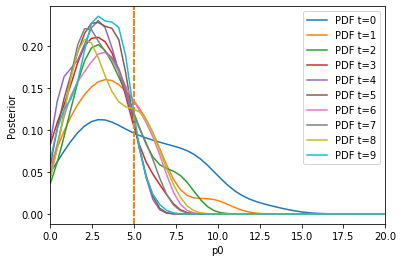

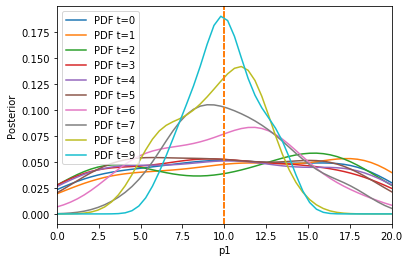

In [3]:
# plotting

def plot(history):
    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=20,
                                        x='p0', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()

    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=20,
                                        x='p1', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()
    
plot(history1)

Next, we use adaptive distances but no factors:

INFO:History:Start <ABCSMC(id=8, start_time=2019-09-28 17:27:08.131655, end_time=None)>
INFO:Epsilon:initial epsilon is 610.2602990802163
INFO:ABC:t:0 eps:610.2602990802163
INFO:ABC:t:1 eps:250.34386417313286
INFO:ABC:t:2 eps:118.85255367777161
INFO:ABC:t:3 eps:49.1100202489351
INFO:ABC:t:4 eps:24.13561784432918
INFO:ABC:t:5 eps:14.910243939113652
INFO:ABC:t:6 eps:8.691074756041264
INFO:ABC:t:7 eps:5.8745180925491765
INFO:ABC:t:8 eps:3.5504707884887883
INFO:ABC:t:9 eps:2.77738514550248
INFO:History:Done <ABCSMC(id=8, start_time=2019-09-28 17:27:08.131655, end_time=2019-09-28 17:29:01.790806)>


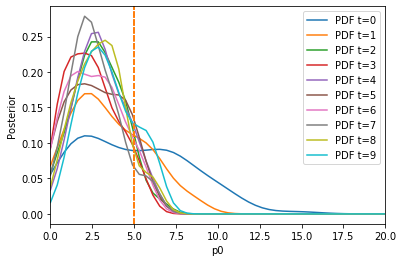

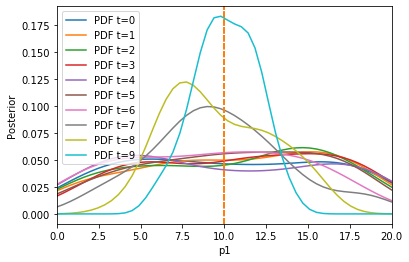

In [4]:
distance = pyabc.AdaptivePNormDistance(p=1, )#factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history2 = abc.run(max_nr_populations=10)

plot(history2)

Next, we account for the discrepancy in data point counts by using factors:

INFO:History:Start <ABCSMC(id=9, start_time=2019-09-28 17:29:02.792248, end_time=None)>
INFO:Epsilon:initial epsilon is 13.189499442179173
INFO:ABC:t:0 eps:13.189499442179173
INFO:ABC:t:1 eps:7.918334676954993
INFO:ABC:t:2 eps:5.295425029379044
INFO:ABC:t:3 eps:4.016167823356356
INFO:ABC:t:4 eps:2.6942779377150843
INFO:ABC:t:5 eps:1.9155672123514351
INFO:ABC:t:6 eps:1.3140443610758967
INFO:ABC:t:7 eps:0.8568813470849236
INFO:ABC:t:8 eps:0.5978402483949025
INFO:ABC:t:9 eps:0.42343468726336797
INFO:History:Done <ABCSMC(id=9, start_time=2019-09-28 17:29:02.792248, end_time=2019-09-28 17:29:40.845917)>


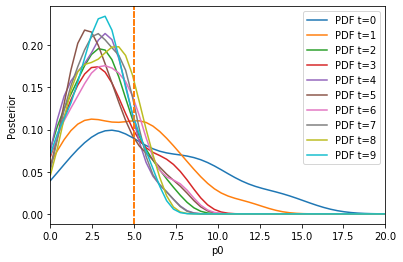

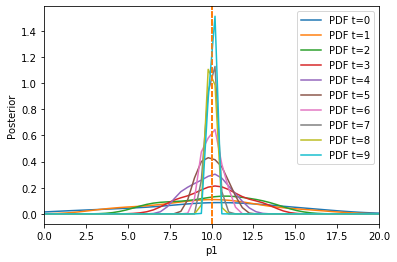

In [5]:
factors = {}
for j in range(N0):
    factors['p0_' + str(j)] = 1/N0
for j in range(N1):
    factors['p1_' + str(j)] = 1/N1
distance = pyabc.PNormDistance(p=1, factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history3 = abc.run(max_nr_populations=10)

plot(history3)

Next, we consider automatic weighting and factors:

INFO:History:Start <ABCSMC(id=10, start_time=2019-09-28 17:29:41.740409, end_time=None)>
INFO:Epsilon:initial epsilon is 11.2424869389359
INFO:ABC:t:0 eps:11.2424869389359
INFO:ABC:t:1 eps:8.14369779599098
INFO:ABC:t:2 eps:6.12717714242134
INFO:ABC:t:3 eps:4.334606418290611
INFO:ABC:t:4 eps:3.2422274217903824
INFO:ABC:t:5 eps:3.1127056881127135
INFO:ABC:t:6 eps:2.2597570319785865
INFO:ABC:t:7 eps:1.9776567902288713
INFO:ABC:t:8 eps:1.6410667575250375
INFO:ABC:t:9 eps:1.3615661397791212
INFO:History:Done <ABCSMC(id=10, start_time=2019-09-28 17:29:41.740409, end_time=2019-09-28 17:30:17.797652)>


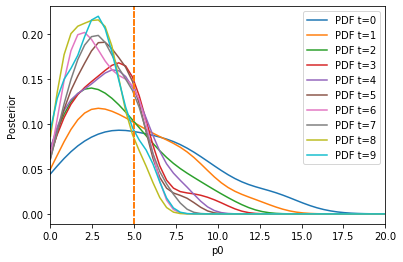

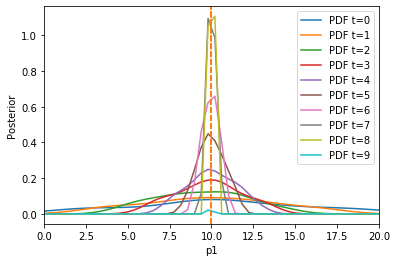

In [6]:
import logging
df_logger = logging.getLogger('Distance')
# df_logger.setLevel(logging.DEBUG)

factors = {}
for j in range(N0):
    factors['p0_' + str(j)] = 1/N0
for j in range(N1):
    factors['p1_' + str(j)] = 1/N1
distance = pyabc.AdaptivePNormDistance(p=1, factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history4 = abc.run(max_nr_populations=10)

plot(history4)

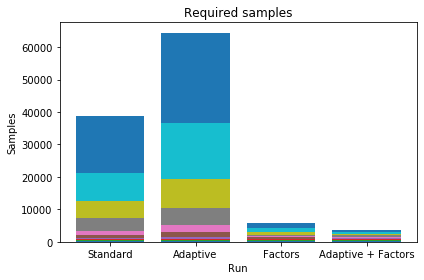

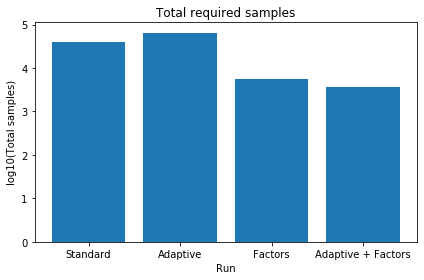

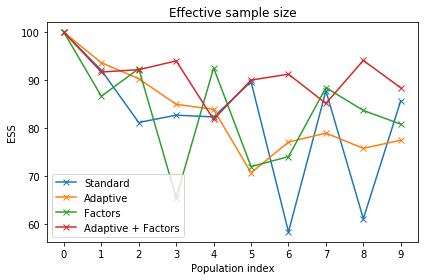

In [7]:
histories = [history1, history2, history3, history4]
labels = ["Standard", "Adaptive", "Factors", "Adaptive + Factors"]

pyabc.visualization.plot_sample_numbers(histories, labels)
pyabc.visualization.plot_total_sample_numbers(histories, labels, yscale='log10')
pyabc.visualization.plot_effective_sample_sizes(histories, labels)

## Aggregating diverse distance functions

Now, we want to combine different distance metrics operating on subsets of the data to one distance value. We consider a slightly advanced model, combining a conversion reaction ODE model with samples from a normal distribution.

In [8]:
import pyabc
import numpy as np
import scipy as sp
from scipy import stats
import os
import tempfile
import matplotlib.pyplot as plt

# true parameters
theta1_true, theta2_true = sp.exp([-2.5, -2])
theta_true = dict(theta1=theta1_true, theta2=theta2_true)

In [9]:
# conversion reaction (cr) model

measurement_data = sp.array([0.0244, 0.0842, 0.1208,
                             0.1724, 0.2315, 0.2634,
                             0.2831, 0.3084, 0.3079,
                             0.3097, 0.3324])
measurement_times = sp.arange(len(measurement_data))      
init = sp.array([1, 0])


def f(y, t0, theta1, theta2):
    x1, x2 = y
    dx1 = - theta1 * x1 + theta2 * x2
    dx2 =   theta1 * x1 - theta2 * x2
    return dx1, dx2


def cr_model(p):
    sol = sp.integrate.odeint(
             f, init, measurement_times,
             args=(p["theta1"], p["theta2"]))
    return {"X_2": sol[:,1]}


def cr_l1_distance(simulation, data):
    return sp.absolute(data["X_2"] - simulation["X_2"]).sum()

In [10]:
# normal distribution samples


def gauss_model(p):
    samples = p['theta1'] + np.random.normal(size=100)
    return {'samples': samples}


def gauss_ks_distance(simulation, data):
    return stats.ks_2samp(simulation['samples'], data['samples']).statistic

observed_samples = gauss_model(theta_true)['samples']
# observation
observation = {'X_2': measurement_data,
               'samples': observed_samples}

The key is now to use `pyabc.distance.AggregatedDistance` to combine both.

In [11]:
def model(p):
    cr_ss = cr_model(p)
    gauss_ss = gauss_model(p)
    return {'X_2': cr_ss['X_2'], 'samples': gauss_model(p)['samples']}


distance = pyabc.distance.AggregatedDistance(
    distances=[cr_l1_distance, gauss_ks_distance], weights=[1, 10])
                           
# prior                           
parameter_prior = pyabc.Distribution(theta1=pyabc.RV("uniform", 0, 1),
                                     theta2=pyabc.RV("uniform", 0, 1))


abc = pyabc.ABCSMC(models=model,
                   parameter_priors=parameter_prior,
                   distance_function=distance,)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
h = abc.run(minimum_epsilon=0.1, max_nr_populations=5)

INFO:History:Start <ABCSMC(id=11, start_time=2019-09-28 17:30:20.356719, end_time=None)>
INFO:Epsilon:initial epsilon is 4.652412879403819
INFO:ABC:t:0 eps:4.652412879403819
INFO:ABC:t:1 eps:2.874360622302195
INFO:ABC:t:2 eps:2.154369364450897
INFO:ABC:t:3 eps:1.83260485263365
INFO:ABC:t:4 eps:1.5953033756606838
INFO:History:Done <ABCSMC(id=11, start_time=2019-09-28 17:30:20.356719, end_time=2019-09-28 17:30:24.121175)>


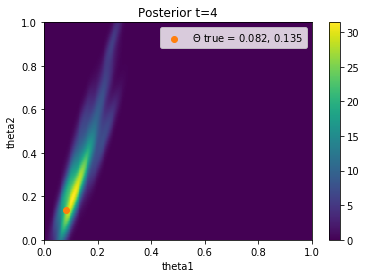

In [12]:
for t in range(h.max_t, h.max_t+1):
    ax = pyabc.visualization.plot_kde_2d(*h.get_distribution(m=0, t=t),
                                         "theta1", "theta2",
                xmin=0, xmax=1, numx=300,
                ymin=0, ymax=1, numy=300)
    ax.scatter([theta1_true], [theta2_true],
                color="C1",
                label='$\Theta$ true = {:.3f}, {:.3f}'.format(
                    theta1_true, theta2_true))
    ax.set_title("Posterior t={}".format(t))
    ax.legend()

In [13]:
for _ in range(10):
    p = dict(parameter_prior.rvs())
    sim = model(p)
    print(p, cr_l1_distance(sim, observation), gauss_ks_distance(sim, observation))
print(theta_true, gauss_ks_distance(observation, observation))

{'theta1': 0.5266742707562301, 'theta2': 0.028830231570544984} 5.820191594378284 0.30000000000000004
{'theta1': 0.395829968623172, 'theta2': 0.05973638967956929} 4.809490177351003 0.18999999999999995
{'theta1': 0.6394670543538569, 'theta2': 0.5831358882923404} 2.6226803731322312 0.2
{'theta1': 0.5718077384919033, 'theta2': 0.8549812438355264} 1.4916426319657048 0.28
{'theta1': 0.419571738457188, 'theta2': 0.08291235446601752} 4.689902557728545 0.17
{'theta1': 0.8358272831047493, 'theta2': 0.12129083998442292} 5.799013023094165 0.2899999999999999
{'theta1': 0.12280528582174799, 'theta2': 0.685653006782916} 1.0431573045393885 0.14
{'theta1': 0.3488753779149766, 'theta2': 0.7154508546582911} 0.725116611234187 0.20000000000000007
{'theta1': 0.6970482386256478, 'theta2': 0.5458409702964514} 2.9914299897280885 0.29
{'theta1': 0.8650017032886246, 'theta2': 0.976908875709582} 2.218355149862144 0.41000000000000003
{'theta1': 0.0820849986238988, 'theta2': 0.1353352832366127} 0.0


## Weighted aggregation

A problem with the previous aggregation of distance function is that usually they vary on different scales. In order to account for all in a similar manner, one thing one can do is to weight them.

Let us look at a simple example of two summary statistics which vary on very different scales:

INFO:History:Start <ABCSMC(id=19, start_time=2019-09-28 17:37:13.987224, end_time=None)>
INFO:Epsilon:initial epsilon is 77.23394820632548
INFO:ABC:t:0 eps:77.23394820632548
INFO:ABC:t:1 eps:36.1084259357034
INFO:ABC:t:2 eps:14.893149289502608
INFO:ABC:t:3 eps:8.087332889160937
INFO:ABC:t:4 eps:4.155600976496801
INFO:ABC:t:5 eps:2.704091694980168
INFO:ABC:t:6 eps:1.4955767224371874
INFO:ABC:t:7 eps:0.8810075856793433
INFO:History:Done <ABCSMC(id=19, start_time=2019-09-28 17:37:13.987224, end_time=2019-09-28 17:38:33.825383)>


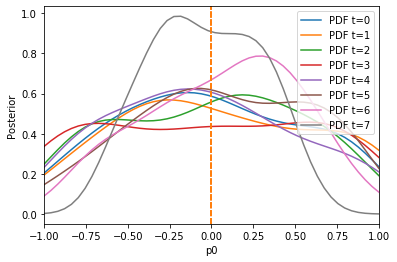

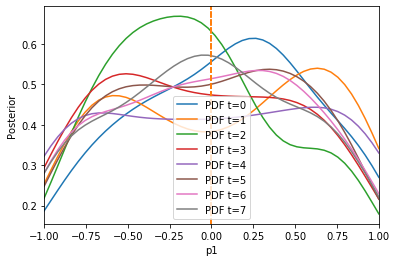

In [25]:
import pyabc
import numpy as np
import scipy as sp
from scipy import stats
import os
import tempfile
import matplotlib.pyplot as plt

p_true = {'p0': 0, 'p1': 0}

def model(p):
    return {'s0': p['p0'] + 0.1 * sp.randn(), 's1': p['p1'] + 100 * sp.randn()}

observation = {'s0': 0, 's1': 0}

def distance0(x, x_0):
    return abs(x['s0'] - x_0['s0'])

def distance1(x, x_0):
    return abs(x['s1'] - x_0['s1'])

# prior                           
prior = pyabc.Distribution(
    p0=pyabc.RV("uniform", -1, 2),
    p1=pyabc.RV("uniform", -1, 2))

distance = pyabc.distance.AggregatedDistance([distance0, distance1])

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history1 = abc.run(max_nr_populations=8)

# plotting

def plot(history):
    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=-1, xmax=1,
                                        x='p0', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()

    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=-1, xmax=1,
                                        x='p1', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()
    
plot(history1)

The algorithm has problems extracting information from the first summary statistic on the first parameter, because the second summary statistic is on a much larger scale. Let us use the `AdaptiveAggregatedDistance` instead, which tries to find good weights itself (and even adapts these weights over time):

INFO:History:Start <ABCSMC(id=20, start_time=2019-09-28 17:38:34.674483, end_time=None)>
INFO:Epsilon:initial epsilon is 0.7062719442031163
INFO:ABC:t:0 eps:0.7062719442031163
INFO:ABC:t:1 eps:0.783013531278589
INFO:ABC:t:2 eps:0.7756153991796289
INFO:ABC:t:3 eps:0.7968669108734868
INFO:ABC:t:4 eps:0.8183984161776898
INFO:ABC:t:5 eps:0.8000195927308278
INFO:ABC:t:6 eps:0.8039403105516124
INFO:ABC:t:7 eps:0.6808037147735478
INFO:History:Done <ABCSMC(id=20, start_time=2019-09-28 17:38:34.674483, end_time=2019-09-28 17:38:49.478812)>


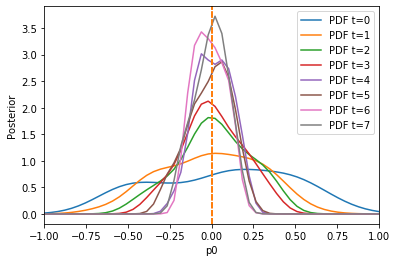

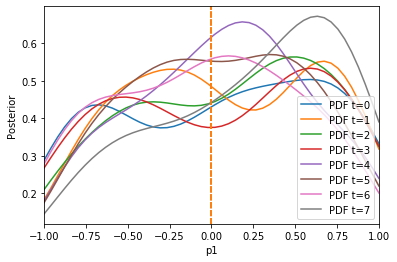

In [26]:
# prior                           
prior = pyabc.Distribution(
    p0=pyabc.RV("uniform", -1, 2),
    p1=pyabc.RV("uniform", -1, 2))

distance = pyabc.distance.distance.AdaptiveAggregatedDistance(
    [distance0, distance1])

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history2 = abc.run(max_nr_populations=8)

plot(history2)

The result is much better. We can also only initially calculate weights by setting `adaptive=False`:

INFO:History:Start <ABCSMC(id=21, start_time=2019-09-28 17:38:50.353925, end_time=None)>
INFO:Epsilon:initial epsilon is 0.7841890347302581
INFO:ABC:t:0 eps:0.7841890347302581
INFO:ABC:t:1 eps:0.528694372940884
INFO:ABC:t:2 eps:0.3371045398072181
INFO:ABC:t:3 eps:0.21618109167767527
INFO:ABC:t:4 eps:0.1549362490351908
INFO:ABC:t:5 eps:0.1253302222808978
INFO:ABC:t:6 eps:0.0883674154186354
INFO:ABC:t:7 eps:0.06240274481042387
INFO:History:Done <ABCSMC(id=21, start_time=2019-09-28 17:38:50.353925, end_time=2019-09-28 17:39:03.398004)>


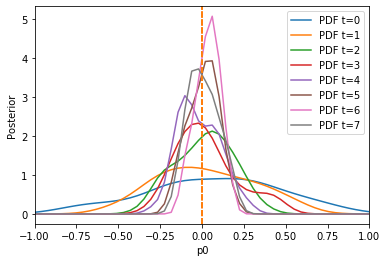

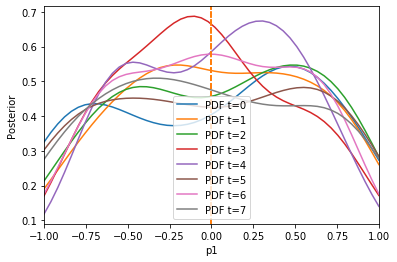

In [27]:
# prior                           
prior = pyabc.Distribution(
    p0=pyabc.RV("uniform", -1, 2),
    p1=pyabc.RV("uniform", -1, 2))

distance = pyabc.distance.distance.AdaptiveAggregatedDistance([distance0, distance1], adaptive=False)

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history3 = abc.run(max_nr_populations=8)

plot(history3)

Here, pre-calibration performs comparable to adaptation, because the weights do not change so much over time.

We can also use other scale functions:

INFO:History:Start <ABCSMC(id=22, start_time=2019-09-28 17:39:04.262206, end_time=None)>
INFO:Epsilon:initial epsilon is 1.9931913012735756
INFO:ABC:t:0 eps:1.9931913012735756
INFO:ABC:t:1 eps:2.1024806471560513
INFO:ABC:t:2 eps:2.240265473147335
INFO:ABC:t:3 eps:2.1100452902697326
INFO:ABC:t:4 eps:2.0793993660309513
INFO:ABC:t:5 eps:2.2133082824780392
INFO:ABC:t:6 eps:2.1268851668691577
INFO:ABC:t:7 eps:2.1960167982978027
INFO:History:Done <ABCSMC(id=22, start_time=2019-09-28 17:39:04.262206, end_time=2019-09-28 17:39:18.188577)>


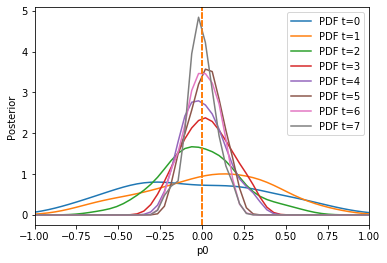

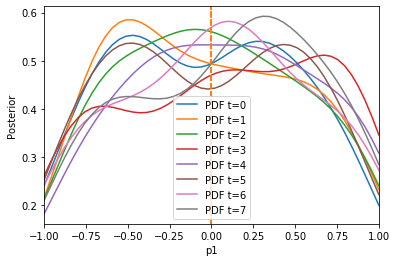

In [28]:
# prior                           
prior = pyabc.Distribution(
    p0=pyabc.RV("uniform", -1, 2),
    p1=pyabc.RV("uniform", -1, 2))

distance = pyabc.distance.distance.AdaptiveAggregatedDistance(
    [distance0, distance1], scale_function=pyabc.distance.scales.mean)

abc = pyabc.ABCSMC(model, prior, distance)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history4 = abc.run(max_nr_populations=8)

plot(history4)

The following plots demonstrate that we not only have a much better posterior approximation after the same number of iterations in the second and third run compared to the first, but we achieve that actually with a much lower number of samples.

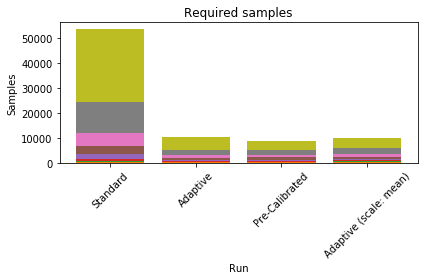

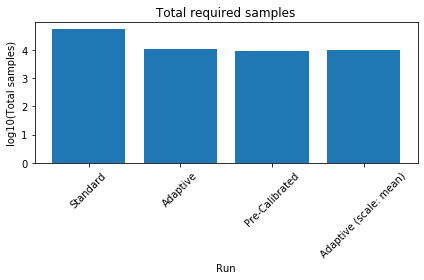

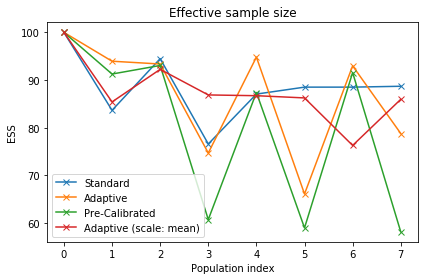

In [29]:
histories = [history1, history2, history3, history4]
labels = ["Standard", "Adaptive", "Pre-Calibrated", "Adaptive (scale: mean)"]

pyabc.visualization.plot_sample_numbers(histories, labels, rotation=45)
pyabc.visualization.plot_total_sample_numbers(histories, labels, yscale='log10', rotation=45)
pyabc.visualization.plot_effective_sample_sizes(histories, labels)